In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Blanchard Kahn solution
class ReturnBK(object):
    def __init__(self, H, R, F, Q):
        self.H = H
        self.R = R
        self.F = F
        self.Q = Q

def BlanchardKahn(A0,A1,B,n,m):
    # Finds solution to the following model: A0 y[t+1] = A1 y[t] + B e[t+1]
    # m: number of non-predetermined (or forward-looking) variables
    
    invA0 = np.linalg.inv(A0)
    A = np.dot(invA0,A1)
    
    Lambda,P = np.linalg.eig(A)
    if sum(np.abs(Lambda)>1)==m:

        idx=np.abs(Lambda).argsort()

        Lambda = np.diag(Lambda[idx])
        P = P[:,idx]

        invP = np.linalg.inv(P)

        Pstar11 = np.real(invP[:n,:n])
        Pstar12 = np.real(invP[:n,n:])
        Pstar21 = np.real(invP[n:,:n])
        Pstar22 = np.real(invP[n:,n:])

        invPstar22 = np.linalg.inv(Pstar22)
        invPstarss = np.linalg.inv(Pstar11 - np.dot(np.dot(Pstar12,invPstar22),Pstar21))


        Lambda1 = np.real(Lambda[:n,:n])
        Lambda2 = np.real(Lambda[n:,n:])

        Q = np.dot(np.dot(invP,invA0),B)
        Q1 = np.real(Q[:n,:n])
        Q2 = np.real(Q[n:,n:])

        H_bk = -np.dot(invPstar22,Pstar21)
        R_bk = np.zeros(shape=(H_bk.shape[0],H_bk.shape[0]))
        F_bk = np.dot(np.dot(invPstarss,Lambda1),Pstar11 - np.dot(np.dot(Pstar12,invPstar22),Pstar21))
        Q_bk = np.dot(invPstarss,Q1)
        
        # Final results
        H = np.concatenate((np.identity(m),np.zeros((m,n))),axis=1)
        R = np.zeros((m,m))
        
        F = np.concatenate((np.zeros((m+n,m)),np.concatenate((np.dot(H_bk,F_bk),F_bk),axis=0)),axis=1)
        Q = np.diagflat(np.sqrt(np.abs(np.concatenate((np.dot(H_bk,Q_bk),Q_bk),axis=0))))

    else: # Blanchard Kahn condition not attended
        H=np.nan
        R=np.nan
        F=np.nan
        Q=np.nan        
    
    return ReturnBK(H, R, F, Q)

In [54]:
# Kalman filter
class ReturnKF(object):
    def __init__(self, yHat, aMinus, VMinus, L):
        self.yHat = yHat
        self.aMinus = aMinus
        self.VMinus = VMinus
        self.L = L

def KalmanFilter(H, R, F, Q, y, forecast):
    # Useful variables and matrices
    m = H.shape[1]
    p = H.shape[0]
    T = y.shape[0] + forecast
    
    yHat   = np.zeros((T  ,p))
    yFull  = np.concatenate((np.array(y),np.nan*np.zeros((forecast,p))),axis=0)
    
    nu     = np.zeros((T  ,p))
    a      = np.zeros((T  ,m))
    aMinus = np.zeros((T+1,m))
    
    S      = np.zeros((T  ,p,p))
    V      = np.zeros((T  ,m,m))
    VMinus = np.array([np.identity(m) for t in range(T+1)])
    K      = np.zeros((T  ,m,p))
    
    Ht     = np.transpose(H)
    Ft     = np.transpose(F)
    
    # Recursevely calculates the Kalman filter
    for t in range(T):
        # Filtered values
        yHat[t] = np.dot(H,aMinus[t])

        for i in range(p):
            if np.isnan(yFull[t][i]):
                yFull[t][i] = yHat[t][i]

        # Update equations    
        nu[t] = yFull[t] - np.dot(H,aMinus[t])
        S[t]  = np.dot(np.dot(H,VMinus[t]),Ht) + R
        K[t]  = np.dot(np.dot(VMinus[t],Ht),np.linalg.inv(S[t]))
        a[t]  = aMinus[t] + np.dot(K[t],nu[t])
        V[t]  = np.dot((np.identity(m)-np.dot(K[t],H)),VMinus[t])

        # Forecast equations
        aMinus[t+1] = np.dot(F,a[t])
        VMinus[t+1] = np.dot(np.dot(F,V[t]),Ft) + Q
        
    # Calculates likelihood
    for t in range(T):
        L = L + np.linalg.det(S[t]) + np.dot(np.dot(np.transpose(nu[t]),np.linalg.inv(S[t])),nu[t])

    L = -T*p/2* np.log(2*np.pi) - 1/2 * L
        
    return ReturnKF(yHat, aMinus, VMinus, L)


In [57]:
sigma = 1.0
beta = 0.99
rho = 0.75
phi_pi = 1.4
v = 1
omega = 0.5
alpha = 3.0

kappa = (1-omega)*(1-beta*omega)/(alpha*omega)

A0 = np.array([[1,0,       0],
               [0,1, 1/sigma],
               [0,0,    beta]])

A1 = np.array([[    rho,     0,           0],
               [1/sigma,     1,phi_pi/sigma],
               [      0,-kappa,           1]])

B = np.array([[v],
              [0],
              [0]])

BK = BlanchardKahn(A0,A1,B,1,2)

df = pd.read_excel('data.xlsx')
dfMissings = pd.DataFrame(df)

probMiss = 0.2
for t in dfMissings.index:
    for i in dfMissings.columns:
        if np.random.rand()<probMiss:
            dfMissings.loc[t,i]=np.nan

KF=KalmanFilter(BK.H, BK.R, BK.F, BK.Q, dfMissings, 10)

In [64]:
%%timeit
BK = BlanchardKahn(A0,A1,B,1,2)
KF = KalmanFilter(BK.H, BK.R, BK.F, BK.Q, df, 10)

100 loops, best of 3: 16.1 ms per loop


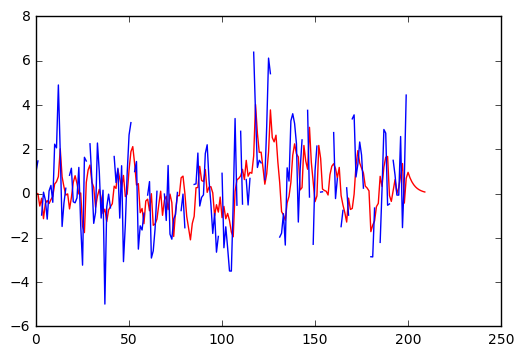

In [58]:
i = 0
plt.plot(range(KF.yHat.shape[0]),[KF.yHat[t,i] for t in range(KF.yHat.shape[0])],'red')
plt.plot(dfMissings[i],'blue')

-2370.1811039853619